<a href="https://colab.research.google.com/github/franz-ob/Forest_Cover_Type_Classification/blob/main/Forest_Cover_Type_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade xgboost pandas scikit-learn

In [3]:
from sklearn.datasets import fetch_covtype
data = fetch_covtype()

In [4]:
import pandas as pd
from sklearn.datasets import fetch_covtype

# Load data
cov = fetch_covtype()
df = pd.DataFrame(data=cov.data, columns=cov.feature_names)
df['target'] = cov.target

# Inspect the target distribution (Crucial for multi-class)
print(df['target'].value_counts(normalize=True))

target
2    0.487599
1    0.364605
3    0.061537
7    0.035300
6    0.029891
5    0.016339
4    0.004728
Name: proportion, dtype: float64


In [5]:
from sklearn.model_selection import train_test_split

# Split into 80% Train, 20% Test
# 'stratify=y' ensures each forest type is represented correctly in both sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('target', axis=1),
    df['target'],
    test_size=0.2,
    random_state=42,
    stratify=df['target']
)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# 1. Define more constrained parameters to save RAM
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [15, 30],
    'min_samples_leaf': [2, 4]
}

# 2. Initialize with max_samples=0.3 and specific n_jobs
rf_search = RandomizedSearchCV(
    RandomForestClassifier(max_samples=0.3),
    rf_params,
    n_iter=3,
    cv=3,
    verbose=2,
    n_jobs=2
)

rf_search.fit(X_train, y_train)
print(f"✅ Best RF Params: {rf_search.best_params_}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ Best RF Params: {'n_estimators': 200, 'min_samples_leaf': 4, 'max_depth': 30}


In [10]:
from sklearn.metrics import classification_report, accuracy_score

# Initialize the 'Final' model with your best params
best_rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=4,
    max_depth=30,
    max_samples=0.3, # Keeping this to ensure memory stays stable
    random_state=42,
    n_jobs=-1 # You can try -1 here since it's just one model now, not a search
)

best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)

print(f"Final RF Accuracy: {accuracy_score(y_test, rf_preds):.4f}")
print(classification_report(y_test, rf_preds))

Final RF Accuracy: 0.9092
              precision    recall  f1-score   support

           1       0.93      0.88      0.91     42368
           2       0.89      0.95      0.92     56661
           3       0.88      0.93      0.90      7151
           4       0.88      0.78      0.83       549
           5       0.95      0.49      0.65      1899
           6       0.89      0.77      0.82      3473
           7       0.96      0.88      0.92      4102

    accuracy                           0.91    116203
   macro avg       0.91      0.81      0.85    116203
weighted avg       0.91      0.91      0.91    116203



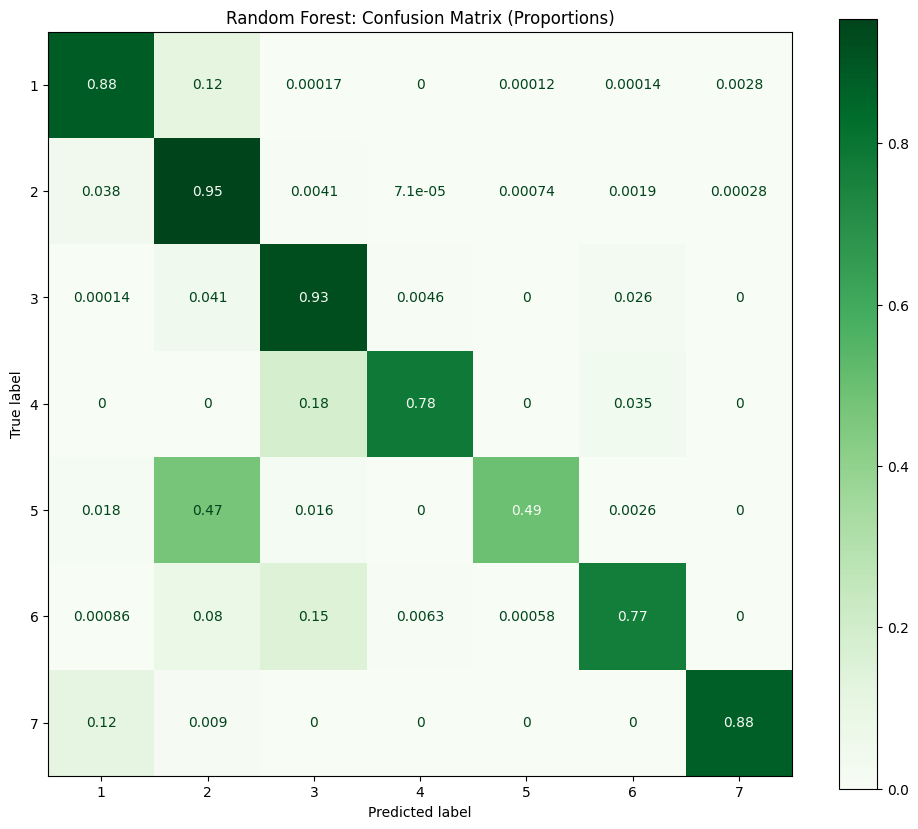

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, rf_preds, normalize='true')
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 8))
disp.plot(cmap='Greens', ax=ax)
plt.title('Random Forest: Confusion Matrix (Proportions)')
plt.show()

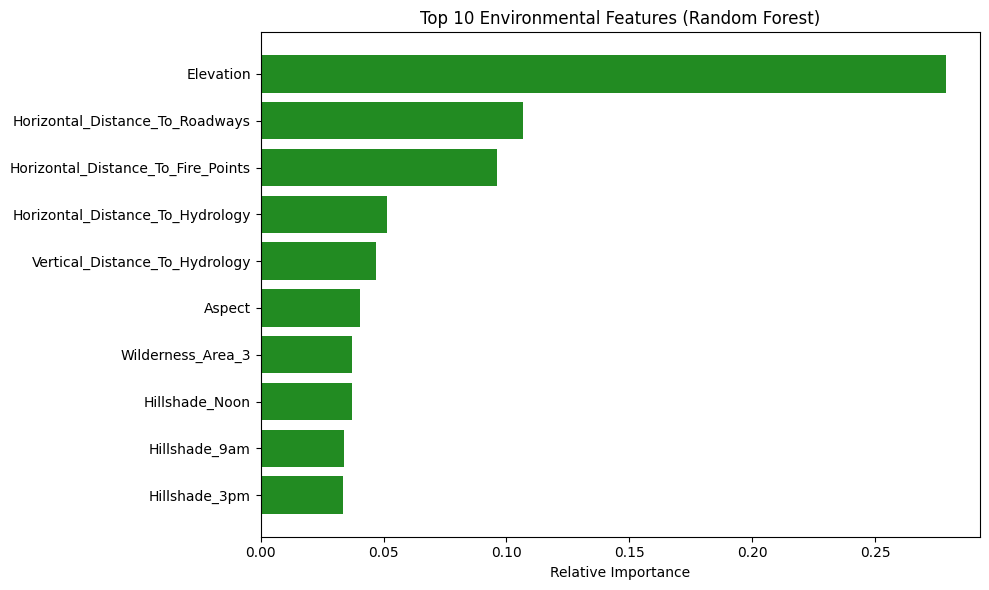

In [14]:
import numpy as np  # Add this line
import matplotlib.pyplot as plt

# The rest of your code remains the same
importances = best_rf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[-10:] # This will work now!

plt.figure(figsize=(10, 6))
plt.title('Top 10 Environmental Features (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='forestgreen', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize with your best found parameters
# Ensure you use 'tree_method="hist"' for speed
best_xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softmax',
    num_class=7,
    tree_method='hist',
    random_state=42
)

# Remeber: XGBoost needs 0-6 labels, not 1-7
best_xgb.fit(X_train, y_train - 1)
xgb_preds = best_xgb.predict(X_test)
xgb_preds = xgb_preds + 1 # Shift back to 1-7 for comparison

In [16]:
import pandas as pd
from sklearn.metrics import f1_score

# Calculate metrics
rf_acc = accuracy_score(y_test, rf_preds)
xgb_acc = accuracy_score(y_test, xgb_preds)

rf_f1 = f1_score(y_test, rf_preds, average='macro')
xgb_f1 = f1_score(y_test, xgb_preds, average='macro')

# Create the summary table
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro F1-Score'],
    'Random Forest': [rf_acc, rf_f1],
    'XGBoost': [xgb_acc, xgb_f1]
})

print("--- Final Model Comparison ---")
print(comparison_df)

--- Final Model Comparison ---
           Metric  Random Forest   XGBoost
0        Accuracy       0.909185  0.842181
1  Macro F1-Score       0.850303  0.809845


<Figure size 1000x600 with 0 Axes>

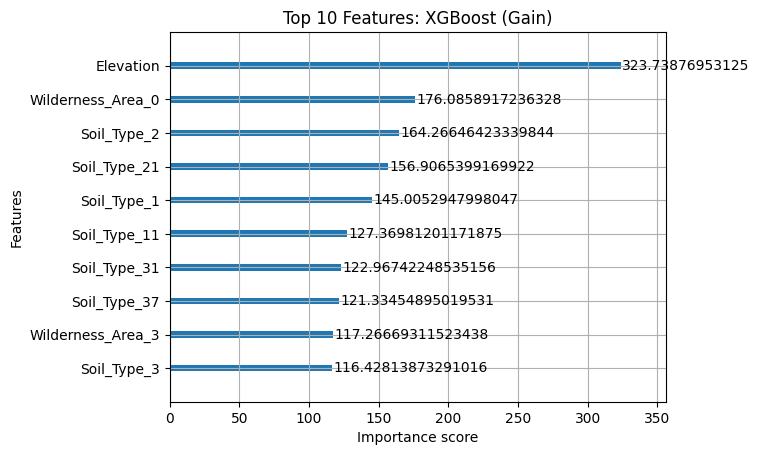

In [17]:
# Plotting XGBoost Feature Importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# XGBoost has a built-in plotting utility
from xgboost import plot_importance
plot_importance(best_xgb, max_num_features=10, importance_type='gain')
plt.title('Top 10 Features: XGBoost (Gain)')
plt.show()

In [18]:
import joblib

# Save the models to files
joblib.dump(best_rf, 'random_forest_covertype.pkl')
joblib.dump(best_xgb, 'xgboost_covertype.pkl')
print("Models saved successfully!")

Models saved successfully!
